In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')
OUTLIERS_LABELLED = os.path.join(DATA_FOLDER, 'outliers_labelled.csv')
NEW_DATASET = os.path.join(DATA_FOLDER, 'final_dataset.csv')

In [3]:
df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

## Outliers using KNN

In [4]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
import networkx as nx

n_neighbors = 20
normalized_df = (df[numerical_attr_list] - df[numerical_attr_list].min()) / (df[numerical_attr_list].max() - df[numerical_attr_list].min())
G = kneighbors_graph(normalized_df.values, n_neighbors=n_neighbors, mode='distance', p=np.inf)
G = nx.DiGraph(G)
dictator = nx.to_dict_of_dicts(G);

In [5]:
score = np.zeros(len(normalized_df))
for element in dictator.keys():
    mean_dist = 0
    for child in dictator[element].keys():
        mean_dist += dictator[element][child]["weight"] / n_neighbors
    score[element] = mean_dist

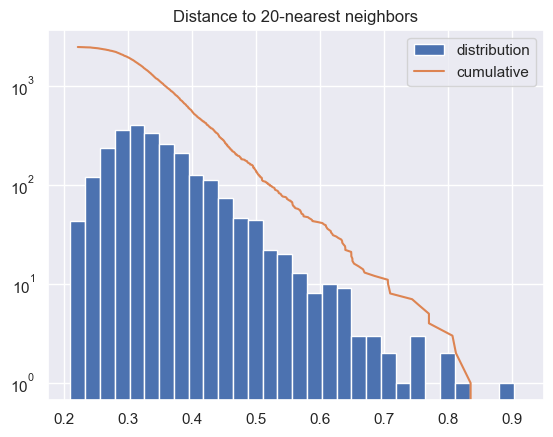

In [6]:
plt.hist(score, bins=30, align="left", label="distribution")
plt.plot(np.flip(np.sort(score)), np.linspace(0, len(df), len(df)), label="cumulative")
plt.yscale('log')
plt.title(f'Distance to {n_neighbors}-nearest neighbors')
plt.legend()
plt.show()

In [7]:
from sklearn.manifold import Isomap

reducer = Isomap(n_neighbors=n_neighbors, p=10)
embedding = reducer.fit_transform(normalized_df)
print(embedding.shape)

(2452, 2)


71


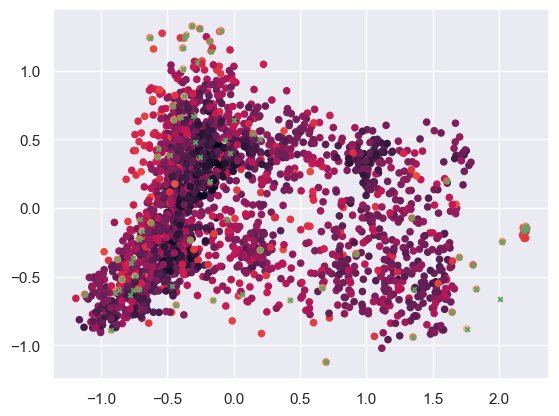

In [8]:
plt.scatter(*embedding.T, c=np.log10(score), s=20)
cutted = embedding[score > 0.55]
print(len(cutted))
plt.scatter(*cutted.T, marker="x", color="g", s=10)
plt.show()

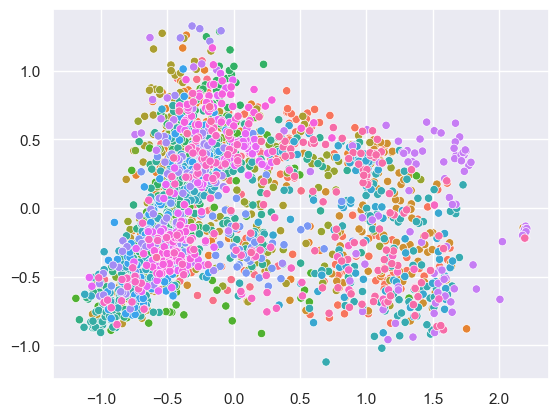

In [9]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['actor'], legend=False)
plt.show()

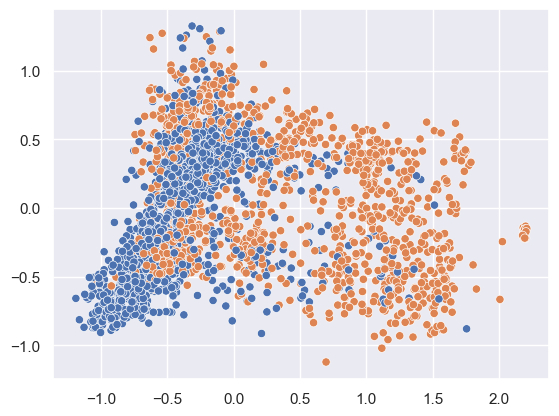

In [10]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['sex'], legend=False)
plt.show()

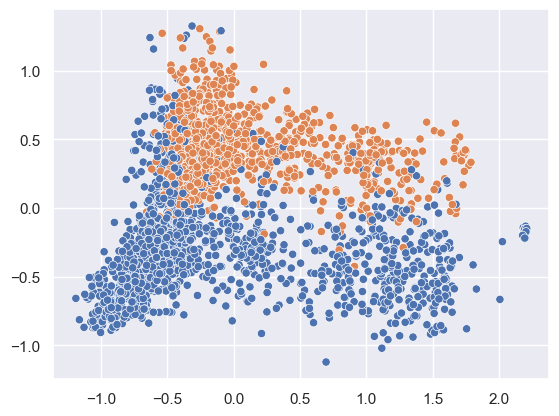

In [11]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["vocal_channel"], legend=False)
plt.show()

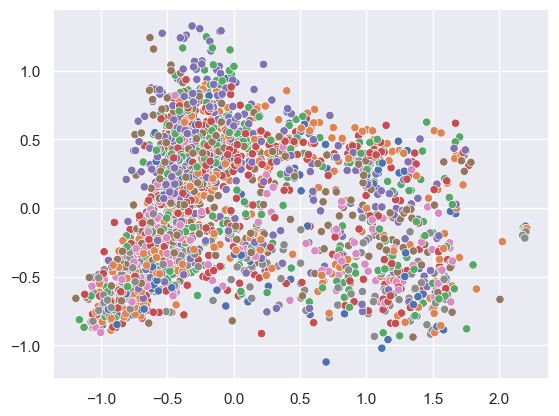

In [12]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["emotion"], legend=False)
plt.show()

In [13]:
from sklearn.decomposition import PCA

def eigenvalues_plot(X):
    pca = PCA()
    pca.fit(X)
    eigenvalues = pca.explained_variance_

    variance = eigenvalues / np.sum(eigenvalues)

    # 50 eigenvalues
    components = np.arange(1, 51)
    variance = variance[:50]

    plt.plot(components, variance, 'bo-')
    plt.xlabel('Principal components')
    plt.ylabel('Variance')
    plt.grid(True)
    plt.show()

In [14]:
df_store = df.copy()

## LOF

In [15]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [16]:
scaler = MinMaxScaler()
X_sex_m = scaler.fit_transform(df_sex_m)
X_sex_f = scaler.fit_transform(df_sex_f)

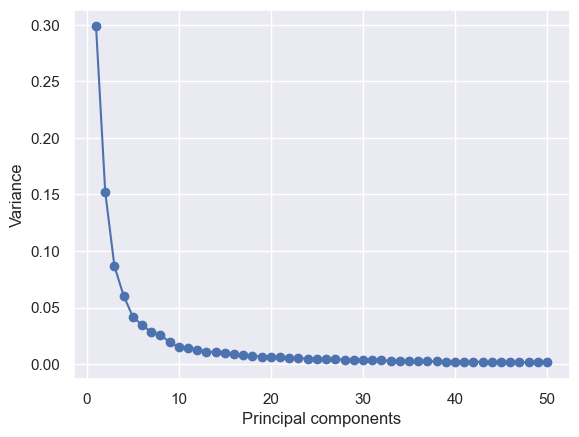

In [17]:
eigenvalues_plot(X_sex_m)

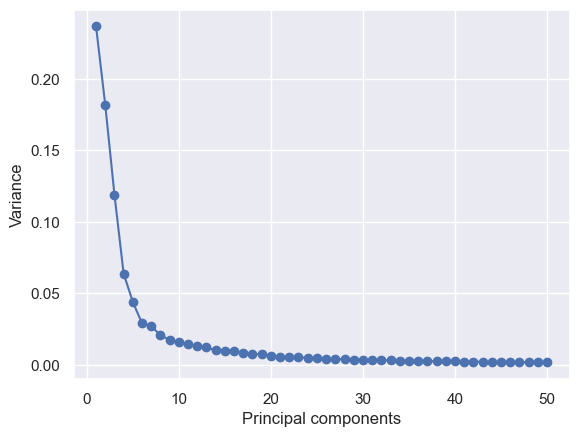

In [18]:
eigenvalues_plot(X_sex_f)

In [19]:
pca = PCA(n_components=5)
X_sex_m = pca.fit_transform(X_sex_m)
X_sex_f = pca.fit_transform(X_sex_f)

In [20]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_sex_m)

In [21]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   8, 1240]))

In [22]:
df_sex_m['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_sex_m['is_outlier'] = is_outlier

In [23]:
clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_sex_f)

In [24]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   5, 1199]))

In [25]:
df_sex_f['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_sex_f['is_outlier'] = is_outlier

In [26]:
df_store['outlier_score_sex_lof'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df_store['is_outlier_sex_lof'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])
df_store[['outlier_score_sex_lof', 'is_outlier_sex_lof']]

,outlier_score_sex_lof,is_outlier_sex_lof
0,-1.162785,False
1,-1.038025,False
2,-1.077281,False
3,-1.020366,False
4,-1.081104,False
...,...,...
2447,-0.988516,False
2448,-1.006351,False
2449,-1.010686,False
2450,-1.029462,False


In [27]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [28]:
X_speech = scaler.fit_transform(df_speech)
X_song = scaler.fit_transform(df_song)

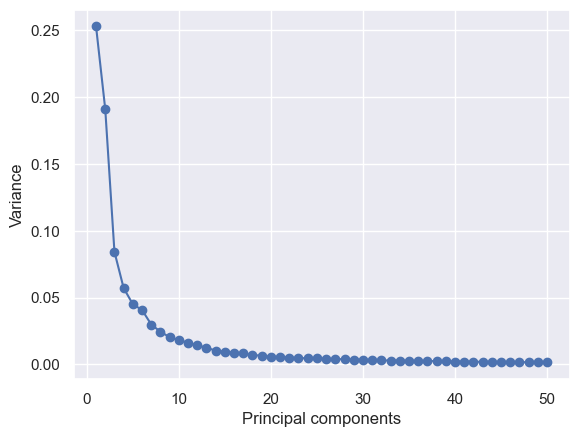

In [29]:
eigenvalues_plot(X_speech)

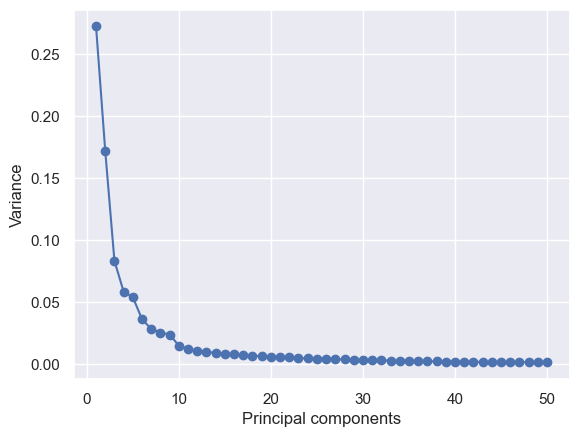

In [30]:
eigenvalues_plot(X_song)

In [31]:
pca = PCA(n_components=5)
X_speech = pca.fit_transform(X_speech)
X_song = pca.fit_transform(X_song)

In [32]:
clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_speech)

In [33]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   7, 1433]))

In [34]:
df_speech['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_speech['is_outlier'] = is_outlier

In [35]:
clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_song)

In [36]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   8, 1004]))

In [37]:
df_song['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_song['is_outlier'] = is_outlier

In [38]:
df_store['outlier_score_vc_lof'] = df_song['outlier_score'].combine_first(df_speech['outlier_score'])
df_store['is_outlier_vc_lof'] = df_song['is_outlier'].combine_first(df_speech['is_outlier'])
df_store[['outlier_score_vc_lof', 'is_outlier_vc_lof']]

,outlier_score_vc_lof,is_outlier_vc_lof
0,-1.194877,False
1,-1.080910,False
2,-1.137766,False
3,-1.020084,False
4,-1.069881,False
...,...,...
2447,-1.002921,False
2448,-1.018316,False
2449,-1.029578,False
2450,-1.010099,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [39]:
df_outliers = df_store.loc[(df_store['is_outlier_sex_lof'] == True) | (df_store['is_outlier_vc_lof'] == True)]

In [40]:
scores = df_outliers['outlier_score_sex_lof'] + df_outliers['outlier_score_vc_lof']
scores_vc = df_outliers['outlier_score_vc_lof']
scores_sex = df_outliers['outlier_score_sex_lof']
scores

35     -2.840765
40     -2.642121
235    -2.934468
382    -3.605933
512    -2.670147
515    -2.628190
589    -3.247020
698    -3.821578
832    -3.782129
841    -2.998252
843    -3.169815
903    -2.974454
1176   -2.700368
1283   -2.731850
1390   -3.162696
1756   -2.910173
1757   -3.074569
1877   -2.991213
1878   -2.708621
2210   -2.969698
2287   -2.958664
2392   -4.248098
dtype: float64

In [41]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)

top1pct_outliers_sex_lof = scores_sex.nsmallest(one_percent)
top1pct_outliers_vc_lof = scores_vc.nsmallest(one_percent)
top1pct_outliers_lof = scores.nsmallest(one_percent)
top1pct_outliers_lof

2392   -4.248098
698    -3.821578
832    -3.782129
382    -3.605933
589    -3.247020
843    -3.169815
1390   -3.162696
1757   -3.074569
841    -2.998252
1877   -2.991213
903    -2.974454
2210   -2.969698
2287   -2.958664
235    -2.934468
1756   -2.910173
35     -2.840765
1283   -2.731850
1878   -2.708621
1176   -2.700368
512    -2.670147
40     -2.642121
515    -2.628190
dtype: float64

## Isolation Forest

In [42]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [43]:
X_sex_m = scaler.fit_transform(df_sex_m)
X_sex_f = scaler.fit_transform(df_sex_f)

In [44]:
from sklearn.ensemble import IsolationForest

isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_sex_m)

In [45]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  50, 1198]))

In [46]:
df_sex_m['outlier_score'] = isfo.score_samples(X_sex_m)

is_outlier = np.where(outliers == 1, False, True)
df_sex_m['is_outlier'] = is_outlier

In [47]:
isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_sex_f)

In [48]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  47, 1157]))

In [49]:
df_sex_f['outlier_score'] = isfo.score_samples(X_sex_f)

is_outlier = np.where(outliers == 1, False, True)
df_sex_f['is_outlier'] = is_outlier

In [50]:
df_store['outlier_score_sex_isfo'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df_store['is_outlier_sex_isfo'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])
df_store[['outlier_score_sex_isfo', 'is_outlier_sex_isfo']]

,outlier_score_sex_isfo,is_outlier_sex_isfo
0,-0.481439,False
1,-0.434595,False
2,-0.432841,False
3,-0.415347,False
4,-0.423008,False
...,...,...
2447,-0.387858,False
2448,-0.400317,False
2449,-0.408500,False
2450,-0.405498,False


In [51]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [52]:
X_speech = scaler.fit_transform(df_speech)
X_song = scaler.fit_transform(df_song)

In [53]:
isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_speech)

In [54]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  70, 1370]))

In [55]:
df_speech['outlier_score'] = isfo.score_samples(X_speech)

is_outlier = np.where(outliers == 1, False, True)
df_speech['is_outlier'] = is_outlier

In [56]:
isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_song)

In [57]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 53, 959]))

In [58]:
df_song['outlier_score'] = isfo.score_samples(X_song)

is_outlier = np.where(outliers == 1, False, True)
df_song['is_outlier'] = is_outlier

In [59]:
df_store['outlier_score_vc_isfo'] = df_speech['outlier_score'].combine_first(df_song['outlier_score'])
df_store['is_outlier_vc_isfo'] = df_speech['is_outlier'].combine_first(df_song['is_outlier'])
df_store[['outlier_score_vc_isfo', 'is_outlier_vc_isfo']]

,outlier_score_vc_isfo,is_outlier_vc_isfo
0,-0.456719,False
1,-0.415852,False
2,-0.424849,False
3,-0.417140,False
4,-0.415456,False
...,...,...
2447,-0.403077,False
2448,-0.403634,False
2449,-0.434713,False
2450,-0.434329,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [60]:
df_outliers = df_store.loc[(df_store['is_outlier_sex_isfo'] == True) | (df_store['is_outlier_vc_isfo'] == True)]

In [61]:
scores = df_outliers['outlier_score_sex_isfo'] + df_outliers['outlier_score_vc_isfo']
scores_vc = df_outliers['outlier_score_vc_isfo']
scores_sex = df_outliers['outlier_score_sex_isfo']
scores

32     -1.067792
33     -0.997961
34     -0.995963
35     -1.229170
40     -1.028150
          ...   
2131   -1.030710
2210   -1.006697
2234   -1.011685
2235   -1.010509
2383   -0.972726
Length: 146, dtype: float64

In [62]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)

top1pct_outliers_sex_isfo = scores_sex.nsmallest(one_percent)
top1pct_outliers_vc_isfo = scores_vc.nsmallest(one_percent)
top1pct_outliers_isfo = scores.nsmallest(one_percent)
top1pct_outliers_isfo

35     -1.229170
563    -1.183697
560    -1.180158
1862   -1.179641
1283   -1.177744
561    -1.164778
243    -1.162058
657    -1.145609
659    -1.141415
1861   -1.138090
1757   -1.132377
1759   -1.131083
1704   -1.129932
1756   -1.129735
1973   -1.120697
1801   -1.114010
1031   -1.113263
1029   -1.113121
658    -1.111959
1975   -1.108628
1758   -1.100993
241    -1.096803
554    -1.093822
249    -1.090246
dtype: float64

## ABOD

In [63]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [64]:
X_sex_m = scaler.fit_transform(df_sex_m)
X_sex_f = scaler.fit_transform(df_sex_f)

In [65]:
from pyod.models.abod import ABOD

abod = ABOD()
outliers = abod.fit_predict(X_sex_m)

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [66]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1123,  125]))

In [67]:
df_sex_m['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_sex_m['is_outlier'] = is_outlier

In [68]:
abod = ABOD()
outliers = abod.fit_predict(X_sex_f)

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [69]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1083,  121]))

In [70]:
df_sex_f['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_sex_f['is_outlier'] = is_outlier

In [71]:
df_store['outlier_score_sex_abod'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df_store['is_outlier_sex_abod'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])
df_store[['outlier_score_sex_abod', 'is_outlier_sex_abod']]

,outlier_score_sex_abod,is_outlier_sex_abod
0,-0.000272,True
1,-0.005159,False
2,-0.025919,False
3,-0.006972,False
4,-0.002715,False
...,...,...
2447,-0.035669,False
2448,-0.017515,False
2449,-0.007905,False
2450,-0.005445,False


In [72]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [73]:
X_speech = scaler.fit_transform(df_speech)
X_song = scaler.fit_transform(df_song)

In [74]:
abod = ABOD()
outliers = abod.fit_predict(X_speech)

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [75]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1296,  144]))

In [76]:
df_speech['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_speech['is_outlier'] = is_outlier

In [77]:
abod = ABOD()
outliers = abod.fit_predict(X_song)

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [78]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([910, 102]))

In [79]:
df_song['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_song['is_outlier'] = is_outlier

In [80]:
df_store['outlier_score_vc_abod'] = df_speech['outlier_score'].combine_first(df_song['outlier_score'])
df_store['is_outlier_vc_abod'] = df_speech['is_outlier'].combine_first(df_song['is_outlier'])
df_store[['outlier_score_vc_abod', 'is_outlier_vc_abod']]

,outlier_score_vc_abod,is_outlier_vc_abod
0,-0.002171,False
1,-0.010967,False
2,-0.024170,False
3,-0.011800,False
4,-0.011233,False
...,...,...
2447,-0.022206,False
2448,-0.008860,False
2449,-0.003232,False
2450,-0.004058,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [81]:
df_outliers = df_store.loc[(df_store['is_outlier_sex_abod'] == True) | (df_store['is_outlier_vc_abod'] == True)]

In [82]:
scores = df_outliers['outlier_score_sex_abod'] + df_outliers['outlier_score_vc_abod']
scores_vc = df_outliers['outlier_score_vc_abod']
scores_sex = df_outliers['outlier_score_sex_abod']
scores

0      -0.002443
8      -0.003400
13     -0.005057
17     -0.003363
32     -0.002482
          ...   
2425   -0.003687
2426   -0.002269
2437   -0.002124
2440   -0.002044
2443   -0.002981
Length: 338, dtype: float64

In [83]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)
# using ABOD the larger the value, the more abnormal the data
top1pct_outliers_sex_abod = scores_sex.nlargest(one_percent)
top1pct_outliers_vc_abod = scores_vc.nlargest(one_percent)
top1pct_outliers_abod = scores.nlargest(one_percent)
top1pct_outliers_abod

2392   -0.000173
841    -0.000336
352    -0.000382
927    -0.000425
2375   -0.000464
1283   -0.000539
292    -0.000589
1738   -0.000590
546    -0.000613
1367   -0.000652
1862   -0.000679
1968   -0.000691
35     -0.000696
1177   -0.000794
698    -0.000809
2336   -0.000814
92     -0.000818
842    -0.000840
361    -0.000907
1982   -0.000917
1878   -0.000924
955    -0.000927
1702   -0.000956
1496   -0.000972
dtype: float64

In [84]:
df_store.to_csv(OUTLIERS_LABELLED, index=False)

## Compare the outliers obtained by the three different methods

In [85]:
display(top1pct_outliers_lof, top1pct_outliers_sex_lof, top1pct_outliers_vc_lof)

2392   -4.248098
698    -3.821578
832    -3.782129
382    -3.605933
589    -3.247020
843    -3.169815
1390   -3.162696
1757   -3.074569
841    -2.998252
1877   -2.991213
903    -2.974454
2210   -2.969698
2287   -2.958664
235    -2.934468
1756   -2.910173
35     -2.840765
1283   -2.731850
1878   -2.708621
1176   -2.700368
512    -2.670147
40     -2.642121
515    -2.628190
dtype: float64

2392   -2.256195
832    -1.855750
382    -1.830512
698    -1.701646
589    -1.668548
1877   -1.654061
35     -1.570689
1176   -1.566017
1878   -1.555411
40     -1.528674
1390   -1.522318
1283   -1.520908
1756   -1.512142
841    -1.494734
2210   -1.417030
903    -1.408688
1757   -1.404169
235    -1.356049
843    -1.350354
2287   -1.248862
512    -1.162855
515    -0.988996
Name: outlier_score_sex_lof, dtype: float64

698    -2.119932
2392   -1.991903
832    -1.926378
843    -1.819461
382    -1.775420
2287   -1.709802
1757   -1.670400
1390   -1.640378
515    -1.639194
589    -1.578472
235    -1.578419
903    -1.565766
2210   -1.552668
512    -1.507292
841    -1.503518
1756   -1.398031
1877   -1.337152
35     -1.270076
1283   -1.210942
1878   -1.153210
1176   -1.134351
40     -1.113446
Name: outlier_score_vc_lof, dtype: float64

In [86]:
display(top1pct_outliers_isfo, top1pct_outliers_sex_isfo, top1pct_outliers_vc_isfo)

35     -1.229170
563    -1.183697
560    -1.180158
1862   -1.179641
1283   -1.177744
561    -1.164778
243    -1.162058
657    -1.145609
659    -1.141415
1861   -1.138090
1757   -1.132377
1759   -1.131083
1704   -1.129932
1756   -1.129735
1973   -1.120697
1801   -1.114010
1031   -1.113263
1029   -1.113121
658    -1.111959
1975   -1.108628
1758   -1.100993
241    -1.096803
554    -1.093822
249    -1.090246
dtype: float64

35     -0.624620
1283   -0.593024
563    -0.589187
1862   -0.586877
560    -0.584139
243    -0.582764
658    -0.571918
657    -0.571390
1801   -0.569519
561    -0.567676
1973   -0.563918
1031   -0.563255
1029   -0.557761
1177   -0.555582
1704   -0.554874
659    -0.554063
1861   -0.553245
1975   -0.550771
1756   -0.548642
1757   -0.547550
32     -0.547312
241    -0.546390
1759   -0.546146
1878   -0.542944
Name: outlier_score_sex_isfo, dtype: float64

35     -0.604549
561    -0.597102
560    -0.596019
563    -0.594510
1862   -0.592764
659    -0.587351
1759   -0.584937
1861   -0.584845
1757   -0.584827
1283   -0.584720
1756   -0.581093
243    -0.579294
1704   -0.575058
657    -0.574219
1758   -0.567125
249    -0.560988
1966   -0.558853
1975   -0.557857
1973   -0.556780
1029   -0.555359
554    -0.554900
311    -0.554634
562    -0.550866
241    -0.550412
Name: outlier_score_vc_isfo, dtype: float64

In [87]:
display(top1pct_outliers_abod, top1pct_outliers_sex_abod, top1pct_outliers_vc_abod)

2392   -0.000173
841    -0.000336
352    -0.000382
927    -0.000425
2375   -0.000464
1283   -0.000539
292    -0.000589
1738   -0.000590
546    -0.000613
1367   -0.000652
1862   -0.000679
1968   -0.000691
35     -0.000696
1177   -0.000794
698    -0.000809
2336   -0.000814
92     -0.000818
842    -0.000840
361    -0.000907
1982   -0.000917
1878   -0.000924
955    -0.000927
1702   -0.000956
1496   -0.000972
dtype: float64

2392   -0.000081
1177   -0.000109
2383   -0.000116
841    -0.000164
92     -0.000188
1283   -0.000211
2269   -0.000218
546    -0.000223
2375   -0.000239
352    -0.000254
955    -0.000272
0      -0.000272
223    -0.000291
927    -0.000293
292    -0.000325
878    -0.000328
1367   -0.000330
1982   -0.000348
1862   -0.000356
1241   -0.000358
1047   -0.000370
2336   -0.000371
1968   -0.000377
361    -0.000380
Name: outlier_score_sex_abod, dtype: float64

2392   -0.000092
1738   -0.000113
2032   -0.000122
352    -0.000128
927    -0.000132
841    -0.000172
934    -0.000186
2375   -0.000224
698    -0.000230
292    -0.000265
1968   -0.000314
35     -0.000315
1206   -0.000320
1367   -0.000322
1862   -0.000323
1283   -0.000328
2008   -0.000346
2035   -0.000350
614    -0.000356
1861   -0.000381
842    -0.000385
546    -0.000390
1878   -0.000402
923    -0.000403
Name: outlier_score_vc_abod, dtype: float64

In [88]:
common_outliers = list(
    top1pct_outliers_lof.index.intersection(top1pct_outliers_isfo.index).intersection(top1pct_outliers_abod.index)
)
common_outliers

[35, 1283]

In [89]:
common_outliers_lof_isfo = list(
    top1pct_outliers_lof.index.intersection(top1pct_outliers_isfo.index)
)
common_outliers_lof_isfo

[1757, 1756, 35, 1283]

In [90]:
common_outliers_lof_abod = list(
    top1pct_outliers_lof.index.intersection(top1pct_outliers_abod.index)
)
common_outliers_lof_abod

[2392, 698, 841, 35, 1283, 1878]

In [91]:
common_outliers_abod_isfo = list(
    top1pct_outliers_abod.index.intersection(top1pct_outliers_isfo.index)
)
common_outliers_abod_isfo

[1283, 1862, 35]

In [92]:
union = list(set(common_outliers_lof_abod + common_outliers_lof_isfo + common_outliers_abod_isfo))
union

[35, 1283, 1862, 841, 1878, 2392, 698, 1756, 1757]